# Twitter Sentiment Analysis on Airlines

## Part A) Text preprocessing

In [3]:
import nltk
import numpy as np
import pandas as pd
import inspect
import preprocessor
np.random.seed(37)
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import countplot, distplot, heatmap
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessor.api import clean

In [4]:
#Loading the data
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


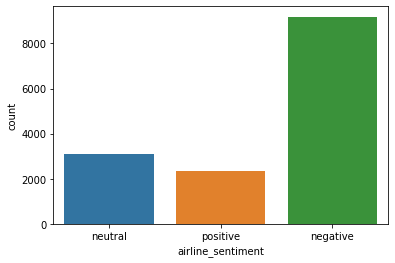

In [5]:
# Visualizing the different sentiment classes: Mostly negative tweets
countplot(x="airline_sentiment", data=df)

In [6]:
# Cleaning tweets
df['prep']=[clean(doc) for doc in df['text']]
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,prep
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take ano...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""ent..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


In [30]:
#Cleaning removes URLS, Hashtags, Mentions, reserved words, emojis, smileys and numbers
print(inspect.getsource(preprocessor.defines.Patterns))

class Patterns:
    URL_PATTERN_STR = r"""(?i)((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info
                      |int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|
                      bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|
                      cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|
                      gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|
                      la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|
                      nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|
                      sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx

## Part B) Sentiment Analysis with NLP

### TextBlob

In [7]:
#TextBlob polarity. One could also get subjectivity
df['sentiment_tb'] = df['prep'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,prep,sentiment_tb
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.,0.000000
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...,0.000000
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take ano...,-0.390625
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""ent...",0.006250
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it,-0.350000


In [8]:
# The polarity is a numerical value that ranges from -1 to 1
# -1 is very negative, while 1 is positive, values around 0 are neutral
# The mean is quite close to zero and std is 0.2, so it seems most of them are classified as neutral
df['sentiment_tb'].describe()

count    14640.000000
mean         0.053555
std          0.320756
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: sentiment_tb, dtype: float64

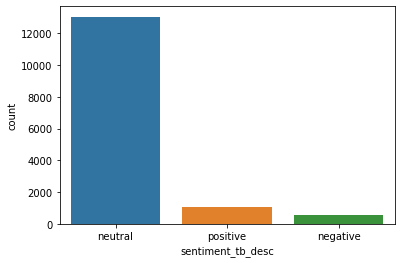

In [26]:
# Hypothesis seems to be confirmed: most are neutral
df['sentiment_tb_desc'] = ['positive' if df['sentiment_tb'][i] > 0.5 else 'negative' if df['sentiment_tb'][i] < -0.5 else 'neutral' for i in range(len(df['sentiment_tb']))]
countplot(x="sentiment_tb_desc", data=df)

In [32]:
# Terrible overall job
# Precision < recall: Underestimation negative -> didn't predict many and for those it predicted wrong
# Inverted case for neutral: predicted a lot, but overestimated
print("Classification Report TextBlob: \n{0}".format(classification_report( df.airline_sentiment,df.sentiment_tb_desc)))

Classification Report TextBlob: 
              precision    recall  f1-score   support

    negative       0.95      0.06      0.11      9178
     neutral       0.22      0.94      0.36      3099
    positive       0.55      0.24      0.34      2363

    accuracy                           0.27     14640
   macro avg       0.57      0.41      0.27     14640
weighted avg       0.73      0.27      0.20     14640



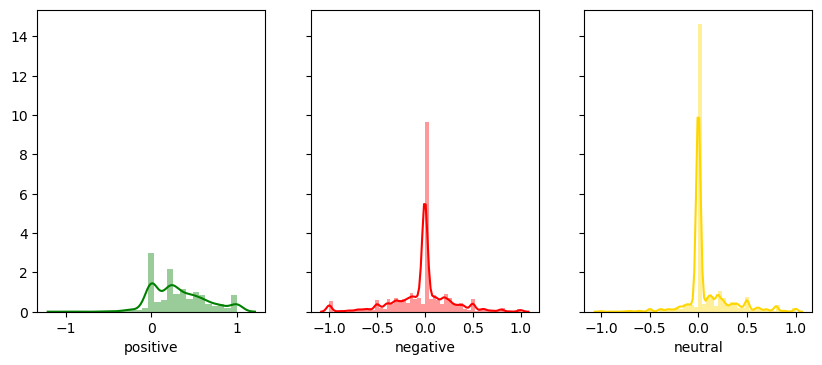

In [31]:
# The three classes have a high concentration on 0! And they overlap a lot, especially neutral and negative
# Positive makes some sense
#Having different boundaries could make sense: e.g. define positive as > 0.2
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=100)
sns.distplot(df.loc[df.airline_sentiment=='positive', "sentiment_tb"] , color="green", ax=axes[0], axlabel='positive')
sns.distplot(df.loc[df.airline_sentiment=='negative', "sentiment_tb"] , color="red", ax=axes[1], axlabel='negative')
sns.distplot(df.loc[df.airline_sentiment=='neutral', "sentiment_tb"] , color="gold", ax=axes[2], axlabel='neutral')

### Vader

In [18]:
# Vader also seems to range from -1 and 1, but we don't find the extremes this time
# Similar mean value. Quite close to 0 => many neutrals
# But higher standard deviation => maybe classifications are a bit more polarized
sid = SentimentIntensityAnalyzer()
df['sentiment_vd'] = df['prep'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])
df['sentiment_vd'].describe()

count    14640.000000
mean         0.051338
std          0.452522
min         -0.966800
25%         -0.296000
50%          0.000000
75%          0.421500
max          0.976000
Name: sentiment_vd, dtype: float64

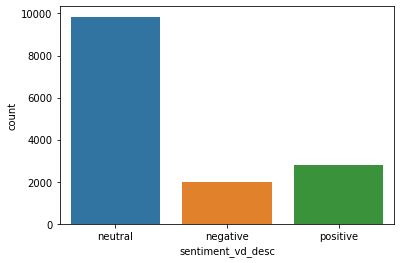

In [23]:
# Predicted more negatives and positives than TextBlob
df['sentiment_vd_desc'] = ['positive' if df['sentiment_vd'][i] > 0.5 else 'negative' if df['sentiment_vd'][i] < -0.5 else 'neutral' for i in range(len(df['sentiment_vd']))]
countplot(x="sentiment_vd_desc", data=df)

In [33]:
# Also overall accuracy mediocre, but slightly better
# Ecpecially better on the positives
# Still missing out quite a lot on the negatives
print("Classification Report Vader: \n{0}".format(classification_report( df.airline_sentiment, df.sentiment_vd_desc)))

Classification Report Vader: 
              precision    recall  f1-score   support

    negative       0.95      0.21      0.34      9178
     neutral       0.26      0.81      0.39      3099
    positive       0.49      0.58      0.53      2363

    accuracy                           0.40     14640
   macro avg       0.56      0.53      0.42     14640
weighted avg       0.73      0.40      0.38     14640



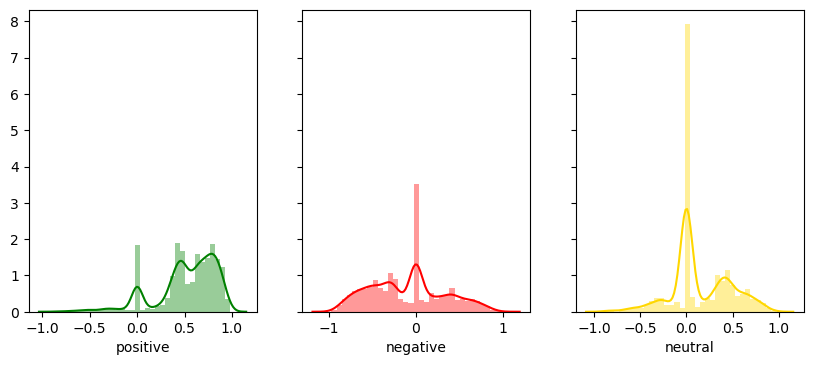

In [34]:
# Positive and negative distributions look better
# Negative is still all over the x axis though
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=100)
sns.distplot(df.loc[df.airline_sentiment=='positive', "sentiment_vd"] , color="green", ax=axes[0], axlabel='positive')
sns.distplot(df.loc[df.airline_sentiment=='negative', "sentiment_vd"] , color="red", ax=axes[1], axlabel='negative')
sns.distplot(df.loc[df.airline_sentiment=='neutral', "sentiment_vd"] , color="gold", ax=axes[2], axlabel='neutral')

## Part C) Supervised sentiment classifier

In [35]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(df.prep,              # x
                                                    df.airline_sentiment, # y
                                                    test_size = 0.20,     # 20% test data 
                                                    random_state = 12)    # random state for reproducibility       

### Train Data

In [37]:
#TF-IDF Vectorizer
vec_tfidf = TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words='english')

#Fitting TF-IDF Vectorizer to !train data!
fitted_vec = vec_tfidf.fit(x_train)

#Transforming the data according to the trained vectorizer
transformer = fitted_vec.transform(x_train)

#Feature names
features = vec_tfidf.get_feature_names()


tf_train = pd.DataFrame(data=transformer.toarray(),
                        index= x_train.index,       # keeping original idices
                        columns=features)           # feature names as columns
tf_train.head()

,aa,agent,agents,airline,airlines,airport,amp,bad,bag,baggage,...,wait,waiting,want,way,weather,website,won,work,worst,yes
11149,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
142,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1405,0.0,0.0,0.0,0.725081,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13024,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8992,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.358059,0.0,0.0,0.0,0.0,0.0,0.0


### Test Data

In [38]:
#Transforming test data according to the vector fitted to the !training data!
transformer_test = fitted_vec.transform(x_test)

tf_test = pd.DataFrame(data=transformer_test.toarray(),
                        index= x_test.index,           # keeping original idices
                        columns=features)              # feature names as columns
tf_test.head()

,aa,agent,agents,airline,airlines,airport,amp,bad,bag,baggage,...,wait,waiting,want,way,weather,website,won,work,worst,yes
14128,0.0,0.0,0.0,0.0,0.0,0.538154,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.565437,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5059,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3813,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.408606,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.371222,0.0,0.0,0.0,0.0,0.0
7445,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
922,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Random Forest Classfier

In [41]:
rf = Pipeline([('tfidf', TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words='english')),  # Tfidf
               ('clf',RandomForestClassifier(random_state = 42)),])                         # Random Forest


rf.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.99, max_features=None,
                                 min_df=0.01, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [42]:
#creating the predictions
y_pred = rf.predict(x_test) 
y_pred

array(['negative', 'positive', 'negative', ..., 'positive', 'negative',
       'negative'], dtype=object)

In [44]:
# Parameters and values to be cross-validated
param_grid = {'min_samples_leaf': [2, 3, 4, 5], 'n_estimators': [10,50,100, 200, 300, 1000]}

rf = RandomForestClassifier(random_state = 42)

#Cross validation on the RF model
grid_search = GridSearchCV(estimator = rf,          # Model
                           param_grid = param_grid, # Dictionary of parameters previously defined
                           cv =10)                  # 10-Fold cross validation

grid_search.fit(tf_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

In [45]:
# Parameters that returned the best RF performance
grid_search.best_params_

{'min_samples_leaf': 2, 'n_estimators': 1000}

In [46]:
# Model using the best RF parameters
best_rf = grid_search.best_estimator_

In [47]:
#Prediction using the best RF parameters
y_pred_best_rf = best_rf.predict(tf_test)
y_pred_best_rf 

array(['negative', 'positive', 'negative', ..., 'positive', 'negative',
       'negative'], dtype=object)

In [48]:
# Quite an improvement overall
# But the neutral class seems to be a challengr
# Since negative is over-represented it has the best score
print("Classification Report: \n{0}".format(classification_report(y_test, y_pred_best_rf)))

Classification Report: 
              precision    recall  f1-score   support

    negative       0.78      0.87      0.83      1876
     neutral       0.50      0.43      0.46       569
    positive       0.70      0.51      0.59       483

    accuracy                           0.73      2928
   macro avg       0.66      0.60      0.63      2928
weighted avg       0.71      0.73      0.72      2928



## Part D) Unsupervised Sentiment Classifier

In [50]:
#TF-IDF Vectorizer
vec_tfidf = TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words='english')

#TF-IDF frequencies
data_tfidf = vec_tfidf.fit_transform(df['prep'])

In [51]:
kmeans = KMeans(n_clusters = 3, max_iter=200)
kmeans.fit(data_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
#Last words (most common) of the centroids list of words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

#Most common words for each cluster
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    
# 0 seems positive
# Could be that both 1 and 2 are negative
# They have thank everywhere
# Great and worse are together in 2, maybe it's neutral?

0 : thanks, thank, just, help, flights, time, plane, amp, bag, hours
1 : flight, cancelled, flightled, delayed, late, time, hours, help, just, thanks
2 : service, customer, worst, flight, thanks, great, hold, amp, thank, just


In [53]:
df['clusters'] = kmeans.labels_
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,tweet_coord,tweet_created,tweet_location,user_timezone,prep,sentiment_tb,sentiment_tb_desc,sentiment_vd,sentiment_vd_desc,clusters
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,...,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.,0.000000,negative,0.0000,negative,0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...,0.000000,negative,0.0000,negative,0
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take ano...,-0.390625,negative,0.0000,negative,0
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""ent...",0.006250,negative,-0.5984,negative,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it,-0.350000,negative,-0.5829,negative,0


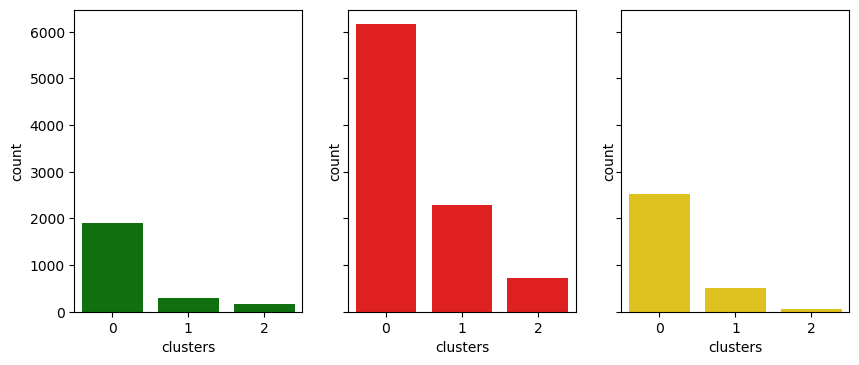

In [58]:
# Everything is mostly assigned to 0
# Can't really assign them to the different classes properly

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=100)
countplot(df.loc[df.airline_sentiment=='positive', "clusters"] , color="green", ax=axes[0]) # Positive
countplot(df.loc[df.airline_sentiment=='negative', "clusters"] , color="red", ax=axes[1])   # Negative
countplot(df.loc[df.airline_sentiment=='neutral', "clusters"] , color="gold", ax=axes[2])   # Neutral

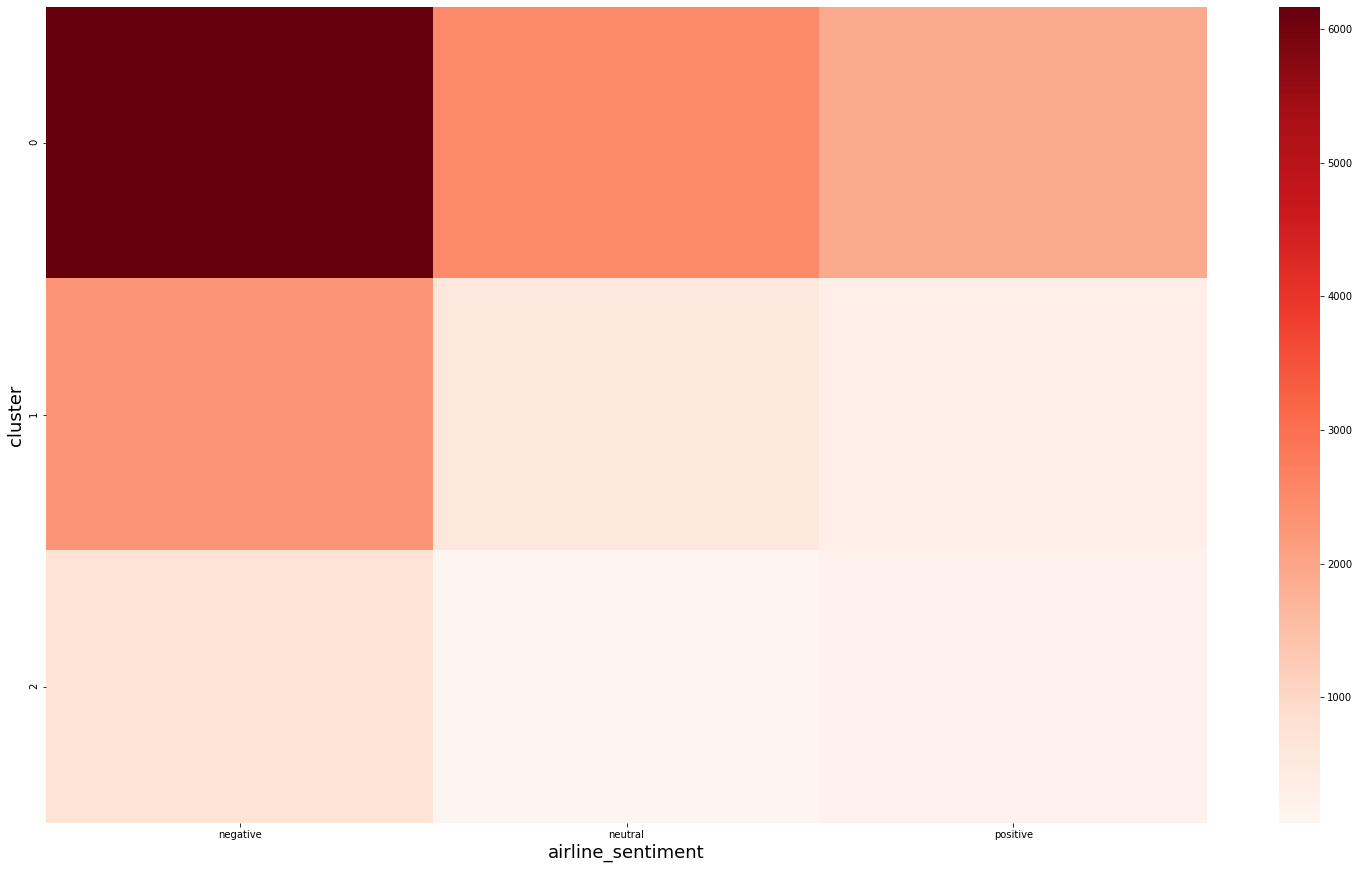

In [54]:
# Heatmap correlating clusters and target names: Everything is mostly in 0 T.T

clusters = df.groupby(['clusters', 'airline_sentiment']).size()
fig, ax1 = plt.subplots(figsize = (26, 15))
heatmap(clusters.unstack(level = 'airline_sentiment'), ax = ax1, cmap = 'Reds')
ax1.set_xlabel('airline_sentiment').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

In [59]:
df.loc[df.clusters == 0,'sentiment_cluster'] = 'negative' 
df.loc[df.clusters == 1,'sentiment_cluster'] = 'neutral' 
df.loc[df.clusters == 2,'sentiment_cluster'] = 'positive' 

In [61]:
# Still has a better overall accuracy than NLP packages
print("Classification Report: \n{0}".format(classification_report(df.airline_sentiment, df.sentiment_cluster)))

Classification Report: 
              precision    recall  f1-score   support

    negative       0.58      0.67      0.62      9178
     neutral       0.17      0.17      0.17      3099
    positive       0.17      0.07      0.10      2363

    accuracy                           0.47     14640
   macro avg       0.31      0.30      0.30     14640
weighted avg       0.43      0.47      0.44     14640



## Conclusion

1. The trained classifier performed significantly better than the other approaches in the Twitter sentiment analysis, but this is somewhat of an unfair comparison, given it's a supervised approach and test data is relatively small.
2. NLP packages can have a better performance if the boundaries are modified
3. K-means didn't do a great job. It probably focused on something other than sentiments 